<h1><center>Lesson 3 — Technical Indicators and Frequency Response (Crypto)</center></h1>

In this lesson we adapt the technical indicators notebook to crypto. We will:
- Fetch crypto OHLCV data
- Build classic indicators: SMA/EMA, MACD, RSI, ATR, Bollinger Bands
- Plot candlesticks with overlays and indicator panels
- Explore the frequency response of a moving-average (FIR) filter to understand what it removes/passes


### Why this matters
Indicators summarize price and volatility information into signals that are easier to reason about. Understanding their behavior (including frequency response) helps avoid over‑fitting and clarifies which market regimes a signal is likely to capture.


### Table of contents
1. Data acquisition (crypto OHLCV)
2. Candlestick plotting
3. SMA/EMA overlays
4. MACD
5. RSI
6. ATR
7. Bollinger Bands
8. Moving‑average frequency response


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

try:
    import yfinance as yf
except Exception:
    yf=None

import warnings as wrn
wrn.filterwarnings('ignore', category=FutureWarning)
wrn.filterwarnings('ignore', category=UserWarning)


### 1. Data acquisition (crypto OHLCV)
We’ll download one symbol to keep visuals readable. You can switch the ticker as you like.


In [2]:
symbol = 'BTC-USD'
start = (pd.Timestamp.now() - pd.Timedelta(days=365)).strftime('%Y-%m-%d')
end = pd.Timestamp.now().strftime('%Y-%m-%d')

if yf is None:
    raise RuntimeError("yfinance not available for this demo")

df = yf.download(symbol, start=start, end=end, interval='1d', progress=False)
df = df.dropna()
df.tail()


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-08-02,112526.914062,114021.601562,112005.765625,113320.390625,56870866000
2025-08-03,114217.671875,114747.421875,111943.804688,112525.804688,48099615826
2025-08-04,115071.882812,115729.468750,114130.406250,114223.921875,35783028986
2025-08-05,114141.445312,115117.437500,112701.109375,115072.187500,61039182286
2025-08-07,117496.898438,117676.906250,114279.710938,115030.054688,64051649681


### 2. Candlestick plotting
Candlesticks show OHLC price action per bar. We’ll use `mplfinance` for convenience.


In [5]:
!pip install mplfinance


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


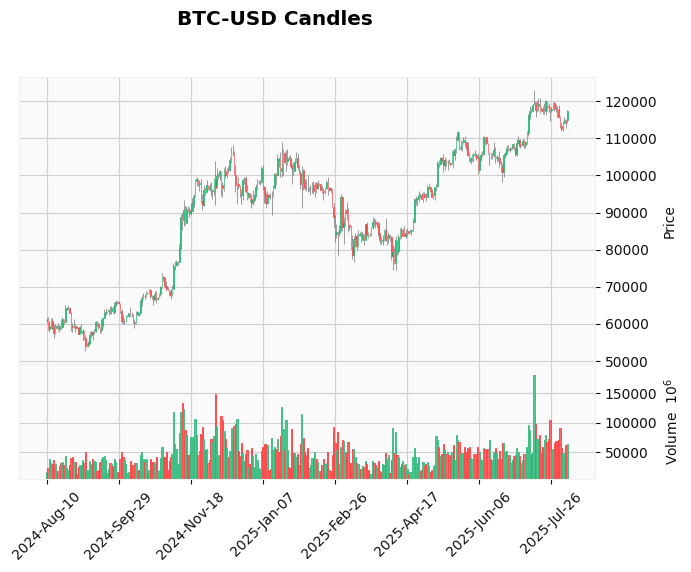

In [7]:
try:
    import mplfinance as mpf
except Exception as e:
    raise RuntimeError("Please install mplfinance: pip install mplfinance") from e

# mplfinance expects a DataFrame with specific column names: 'Open', 'High', 'Low', 'Close'.
# The yfinance library can return a DataFrame with a MultiIndex for columns,
# even for a single ticker, which causes issues with mplfinance.
# To fix this, we check for a MultiIndex and flatten it to a simple Index
# before plotting.
df_for_plot = df.copy()
if isinstance(df_for_plot.columns, pd.MultiIndex):
    # The yfinance MultiIndex is typically ('Open', 'Ticker'), ('High', 'Ticker'), etc.
    # We select the first level of the column index to get ['Open', 'High', ...].
    df_for_plot.columns = df_for_plot.columns.get_level_values(0)

mpf.plot(df_for_plot, type='candle', volume=True, style='yahoo', title=f'{symbol} Candles')


### 3. SMA/EMA overlays
SMA smooths noise with equal weights; EMA emphasizes recent prices. Both are low‑pass filters.


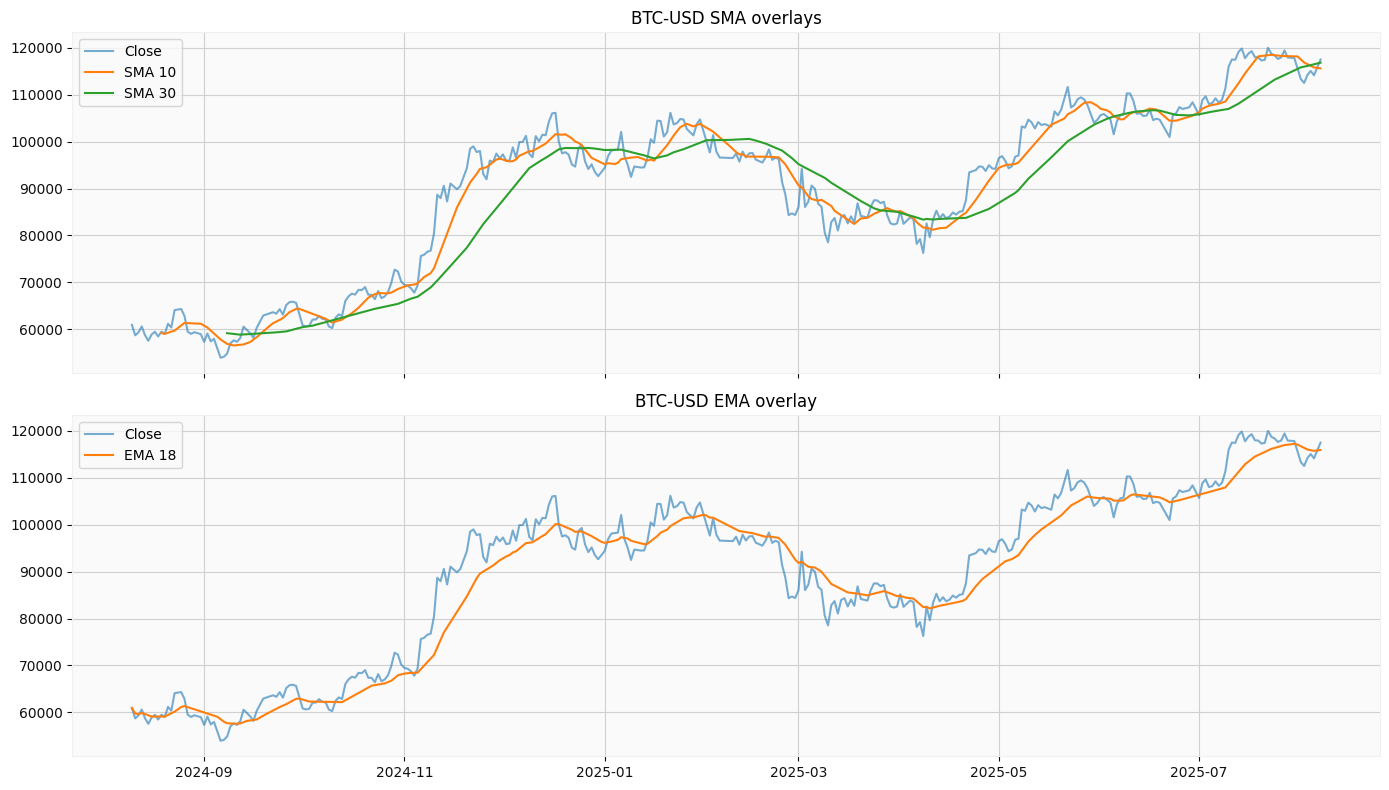

In [8]:
short=10
long=30
sma_short = df['Close'].rolling(window=short).mean()
sma_long = df['Close'].rolling(window=long).mean()
ema_18 = df['Close'].ewm(span=18, adjust=True).mean()

fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(df['Close'], label='Close', alpha=0.6)
ax[0].plot(sma_short, label=f'SMA {short}')
ax[0].plot(sma_long, label=f'SMA {long}')
ax[0].legend(loc='upper left')
ax[0].set_title(f'{symbol} SMA overlays')

ax[1].plot(df['Close'], label='Close', alpha=0.6)
ax[1].plot(ema_18, label='EMA 18')
ax[1].legend(loc='upper left')
ax[1].set_title(f'{symbol} EMA overlay')
plt.tight_layout()


### 4. MACD
MACD = EMA12 − EMA26, with a 9‑period EMA signal. It combines trend and momentum.


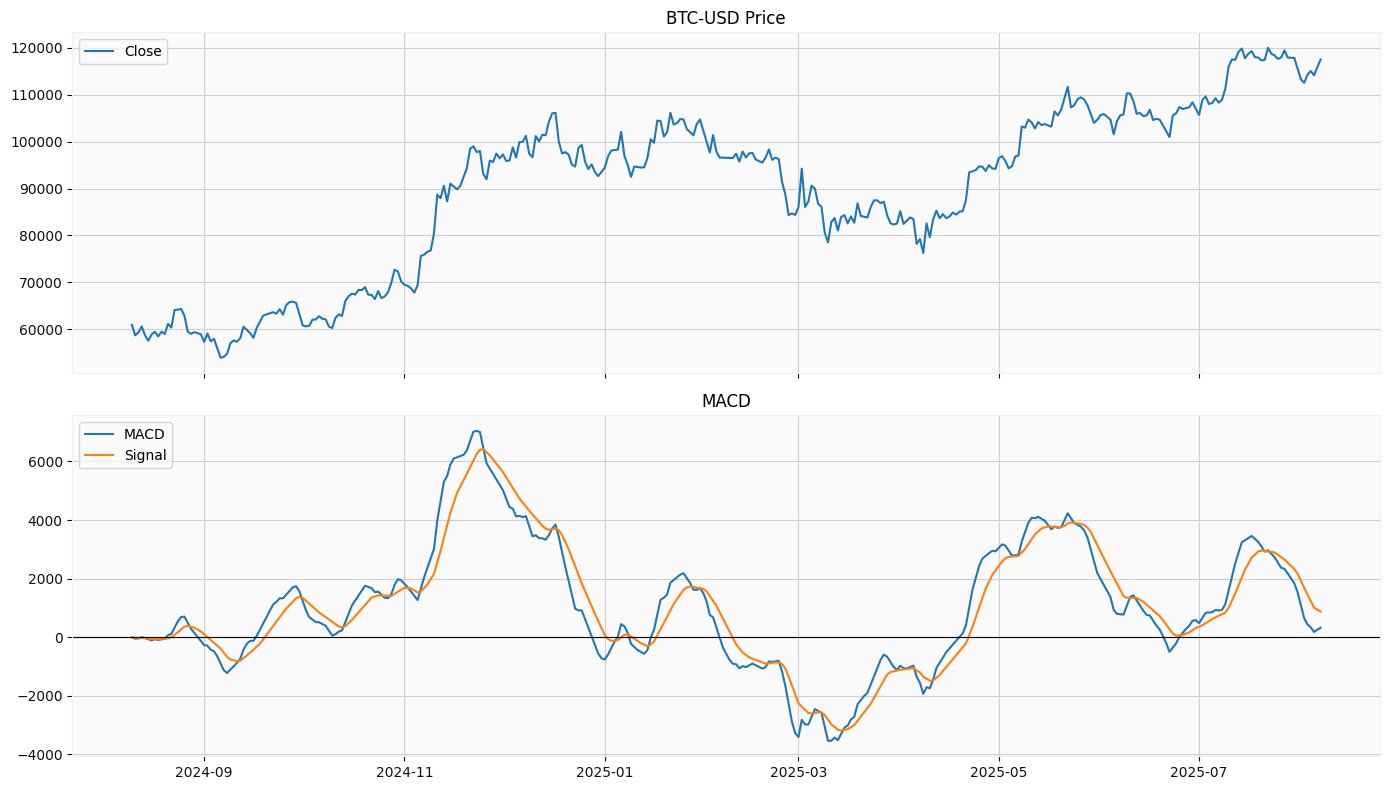

In [9]:
ema12 = df['Close'].ewm(span=12, adjust=True).mean()
ema26 = df['Close'].ewm(span=26, adjust=True).mean()
macd_val = ema12 - ema26
macd_signal = macd_val.ewm(span=9, adjust=True).mean()

fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(df['Close'], label='Close')
ax[0].set_title(f'{symbol} Price')
ax[0].legend(loc='upper left')

ax[1].plot(macd_val, label='MACD')
ax[1].plot(macd_signal, label='Signal')
ax[1].axhline(0, color='k', linewidth=0.8)
ax[1].legend(loc='upper left')
ax[1].set_title('MACD')
plt.tight_layout()


### 5. RSI
RSI measures the magnitude of recent gains vs losses on a fixed window (e.g., 14). Values near 70/30 are often used as overbought/oversold heuristics (context matters).


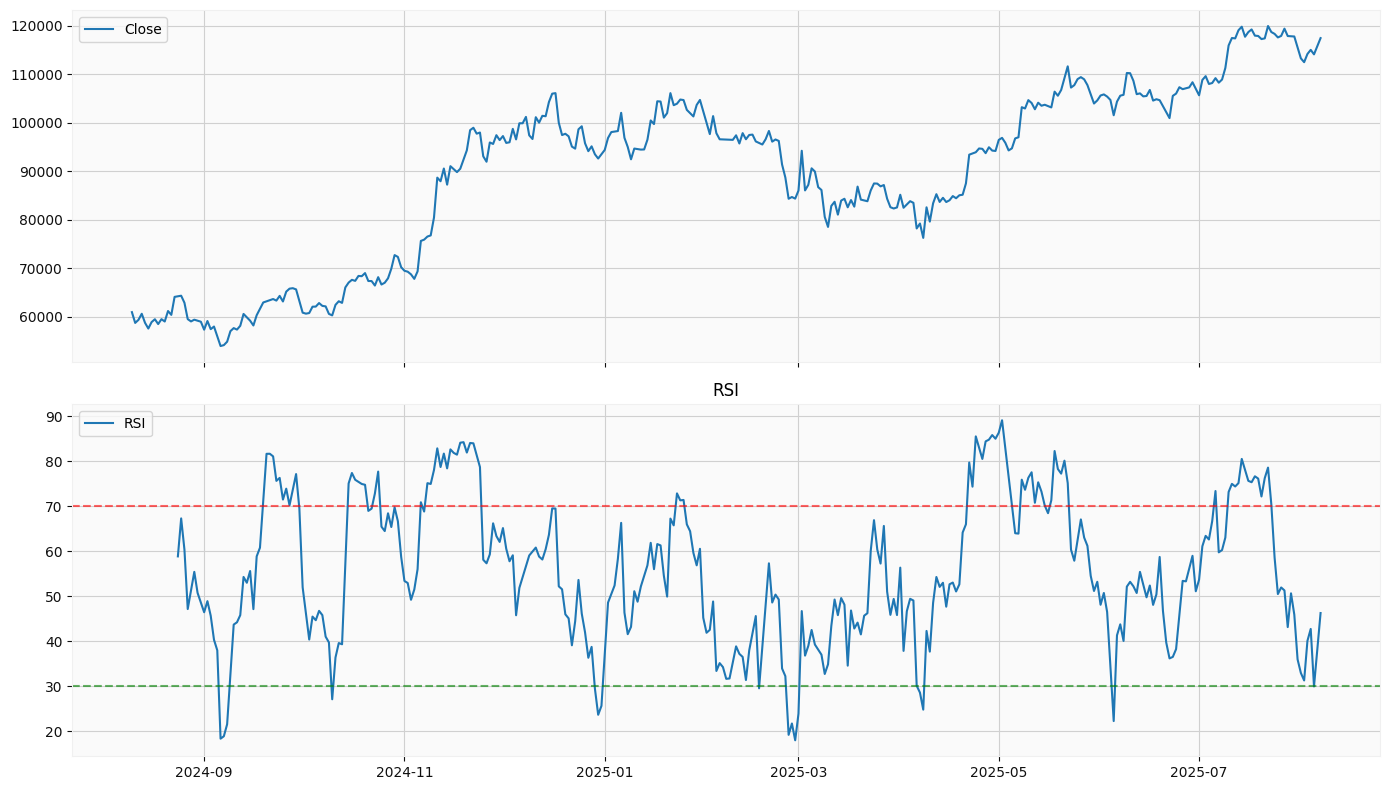

In [10]:
win=14
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = (-delta).clip(lower=0)
roll_up = up.rolling(window=win).mean()
roll_down = down.rolling(window=win).mean()
rs = roll_up/(roll_down+1e-12)
rsi = 100 - (100/(1+rs))

fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(df['Close'], label='Close')
ax[0].legend(loc='upper left')

ax[1].plot(rsi, label='RSI')
ax[1].axhline(70, color='r', linestyle='--', alpha=0.6)
ax[1].axhline(30, color='g', linestyle='--', alpha=0.6)
ax[1].legend(loc='upper left')
ax[1].set_title('RSI')
plt.tight_layout()


### 6. ATR
ATR (Average True Range) measures recent volatility by averaging the true range (max of [high−low, |high−prev_close|, |low−prev_close|]).


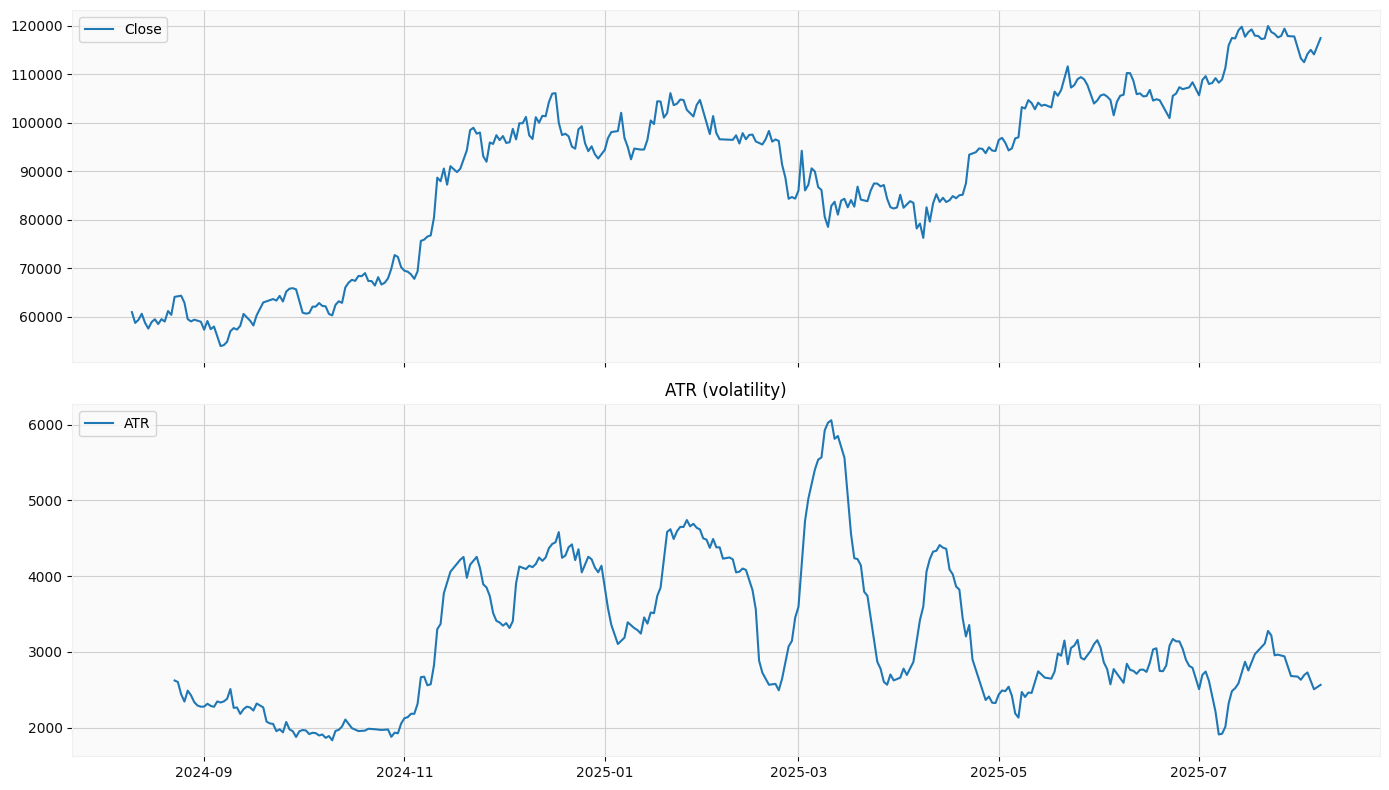

In [11]:
h = df['High']
l = df['Low']
c = df['Close']
prev_c = c.shift(1)
tr = pd.concat([
    (h - l),
    (h - prev_c).abs(),
    (l - prev_c).abs()
], axis=1).max(axis=1)
atr = tr.rolling(window=14).mean()

fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(c, label='Close')
ax[0].legend(loc='upper left')
ax[1].plot(atr, label='ATR')
ax[1].legend(loc='upper left')
ax[1].set_title('ATR (volatility)')
plt.tight_layout()


### 7. Bollinger Bands
Bollinger Bands place an upper/lower band around a moving average, typically ±2 standard deviations.


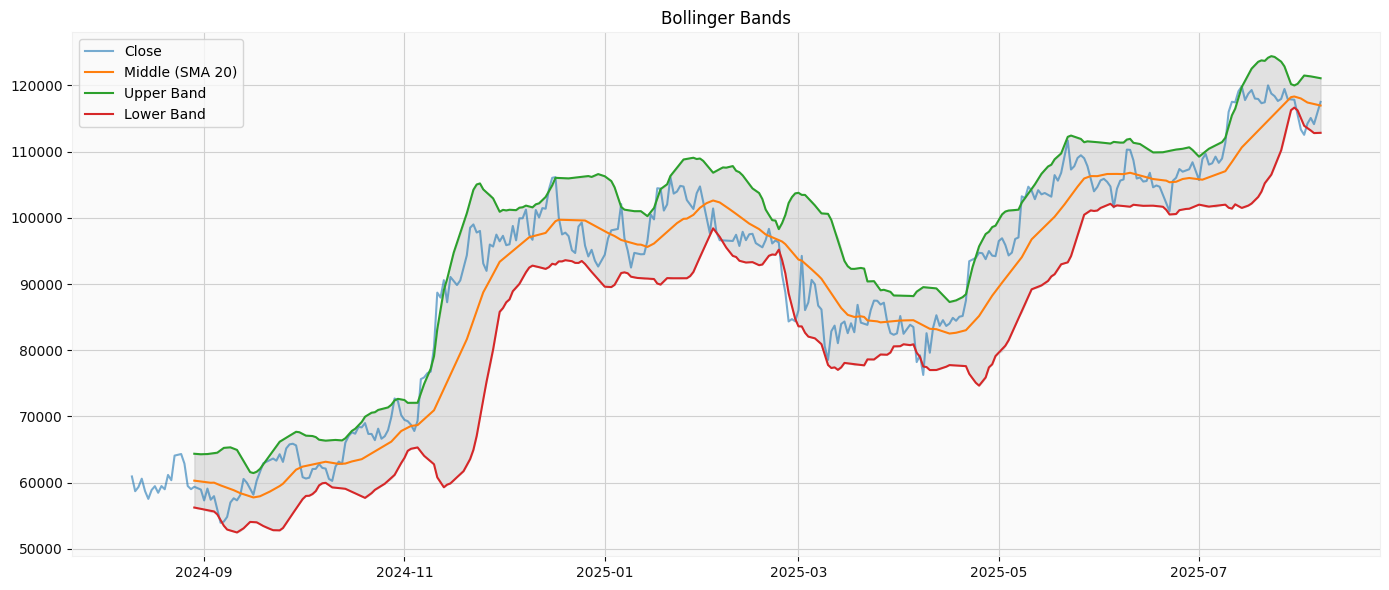

In [13]:
c = df['Close'].squeeze()
mid = c.rolling(window=20).mean()
std = c.rolling(window=20).std()
upper = mid + 2*std
lower = mid - 2*std

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(c, label='Close', alpha=0.6)
ax.plot(mid, label='Middle (SMA 20)')
ax.plot(upper, label='Upper Band')
ax.plot(lower, label='Lower Band')
ax.fill_between(c.index, lower, upper, color='gray', alpha=0.2)
ax.legend(loc='upper left')
ax.set_title('Bollinger Bands')
plt.tight_layout()


### 8. Moving‑average frequency response
A simple SMA is a finite impulse response (FIR) filter. Its frequency response shows which components are passed (low frequencies/trends) and which are attenuated (high‑frequency noise).


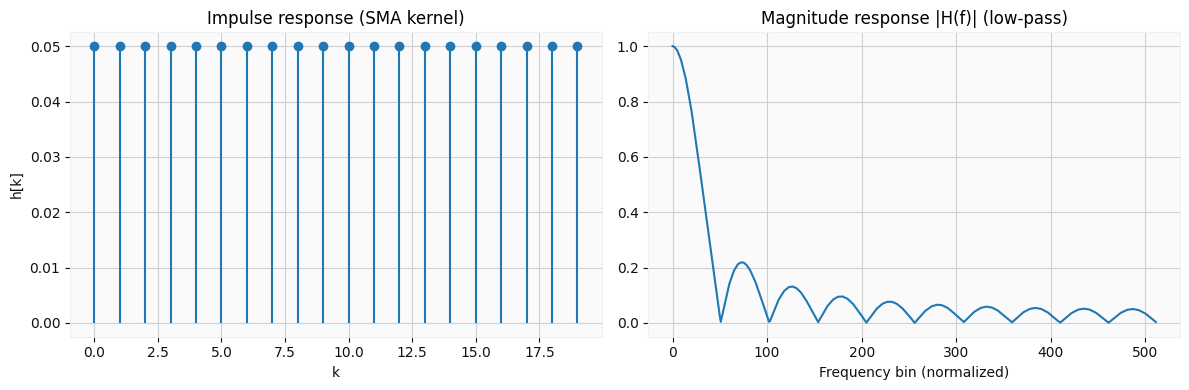

In [14]:
from numpy.fft import fft, fftfreq

N=20  # window length
h = np.ones(N)/N  # SMA kernel
H = fft(h, n=1024)
freqs = fftfreq(len(H), d=1.0)  # normalized frequency

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].stem(range(N), h, basefmt=" ")
ax[0].set_title('Impulse response (SMA kernel)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('h[k]')

ax[1].plot(np.abs(H)[:len(H)//2])
ax[1].set_title('Magnitude response |H(f)| (low‑pass)')
ax[1].set_xlabel('Frequency bin (normalized)')
plt.tight_layout()


In [15]:
symbols = ['BTC-USD', 'ETH-USD', 'ADA-USD']
start_date = (pd.Timestamp.now() - pd.Timedelta(days=180)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

market = pd.DataFrame()

if yf is not None:
    try:
        # Download all symbols at once for efficiency.
        data = yf.download(
            symbols,
            start=start_date,
            end=end_date,
            interval='1d',
            progress=False
        )

        if not data.empty and 'Close' in data.columns:
            market = data['Close']
            # Clean data: drop tickers with no data, then drop days with any missing data
            market = market.dropna(axis=1, how='all')
            market = market.dropna(axis=0, how='any')

        if not market.empty:
            print(f"Successfully downloaded data for: {list(market.columns)}")
        else:
            print("No valid, overlapping data found for the requested symbols.")

    except Exception as e:
        print(f"An error occurred during data download: {e}")
else:
    print("yfinance module 'yf' is not available.")

Successfully downloaded data for: ['ADA-USD', 'BTC-USD', 'ETH-USD']


In [ ]:
symbols = ['BTC-USD', 'ETH-USD', 'ADA-USD']
start_date = (pd.Timestamp.now() - pd.Timedelta(days=180)).strftime('%Y-%m-%d')
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')

market = pd.DataFrame()

if yf is not None:
    try:
        # Download all symbols at once for efficiency.
        data = yf.download(
            symbols,
            start=start_date,
            end=end_date,
            interval='1d',
            progress=False
        )

        if not data.empty and 'Close' in data.columns:
            market = data['Close']
            # Clean data: drop tickers with no data, then drop days with any missing data
            market = market.dropna(axis=1, how='all')
            market = market.dropna(axis=0, how='any')

        if not market.empty:
            print(f"Successfully downloaded data for: {list(market.columns)}")
        else:
            print("No valid, overlapping data found for the requested symbols.")

    except Exception as e:
        print(f"An error occurred during data download: {e}")
else:
    print("yfinance module 'yf' is not available.")

Successfully downloaded data for: ['ADA-USD', 'BTC-USD', 'ETH-USD']
